# Evaluation Task: Decoding quantum states through nuclear magnetic resonance

#### Solutions by Amish Mittal (amishmittal@outlook.com)

### Overview

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins are aligned, let loose, and then refocused, making a sharp peak, or "echo", of the original alignment. When the spins interact with each other, the refocused echo in the magnetization $M$ can become highly distorted.
- Materials with strong electron-electron couplings show a wide variety of phenomena, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- In this evaluation, you will desgin and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$. 
- The four (4) evaluation tasks follow after an introduction to the problem and code which downloads the dataset you will use.


## A quick intro to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!

![HahnEcho_GWM.gif](attachment:HahnEcho_GWM.gif)

The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a spin-echo in most materials:

![standard_spinecho.png](attachment:standard_spinecho.png)

Sometimes, a more complicated curve can occur, such as:

![coupled_echo.png](attachment:coupled_echo.png)

This more complicated structure has been caused by spin-spin interactions between the precessing nuclear spins. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

## Note that the values of $M$ are complex numbers, and above we have just plotted the absolute value $|M|$ for convienence.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough (enhanced perhaps by a "qunatum" electronic phase), then a non-neglible two-step process can couple the nuclei with each other throughout the material.
That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$, given by:

$T_0(i,j) = \alpha \exp{\left[ \left(\frac{-|r_j - r_i|}{\xi} \right)^{2} \right]}$


where $\alpha$ is the coupling strength and $\xi$ the coupling length,.
Generally, $\alpha$ and $\xi$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if a spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost".
This occurs at a time scale $T_\textrm{decay} \simeq \sqrt{\Gamma}$

Our goal is to develop a model that accurately determines the above three variables ($\alpha$, $\xi$, and $\Gamma$) from a single $M(t)$ curve.

## Load and view the simulated data

I began by learning the basics of NMR and spin scho from https://web.eecs.umich.edu/~dnoll/BME516/mri1.pdf and https://web.eecs.umich.edu/~dnoll/BME516/mri3.pdf. A nice and lucid explanation.

In [1]:
# An environment restart may be required depending on version of installed dependencies.
# However, in most cases, it won't be required
!pip install tsfresh==0.17.0 -Uq
!pip install tsai==0.2.15 -Uq
import tsfresh
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import sklearn.model_selection
import pandas as pd
import json
import tsai
import torch
import fastai
import fastcore
import tensorflow as tf
from tsai.all import *
from scipy import stats
from tsfresh import extract_features
from tsfresh import feature_extraction
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.ensemble import RandomForestRegressor

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 686kB 8.3MB/s 
     |████████████████████████████████| 112kB 14.8MB/s 
ERROR: distributed 2021.4.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
     |████████████████████████████████| 143kB 6.6MB/s 
     |████████████████████████████████| 5.7MB 6.8MB/s 
     |████████████████████████████████| 2.5MB 40.9MB/s 
     |████████████████████████████████| 194kB 43.9MB/s 
     |████████████████████████████████| 215kB 37.2MB/s 
     |████████████████████████████████| 9.5MB 42.2MB/s 
     |████████████████████████████████| 3.4MB 41.9MB/s 
     |████████████████████████████████| 901kB 40.7MB/s 
     |████████████████████████████████| 22.3MB 28.9MB/s 
     |████████████████████████████████| 12.8MB 245kB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 25.3MB 139kB/s

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:365: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [2]:
mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

print("Downloading files off google drive...")
# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1DTtUehUa_xNJTJ5zoElLLwYF-ucAX0DZ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1C9RWMtiXtDZFfhfrTDs3665MXPtPBxHN",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1GTQJztXD7HEfs9W661g_t1Sb-oCe_hsV",allow_redirects=True)
open(M_file_i, "wb").write(r.content)
print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   Γ  |
mat_info = np.loadtxt(mat_file, comments="#", delimiter=None, unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter=None, unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter=None, unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")


Done with file downloads
Loading into numpy arrays...
Done with numpy loads


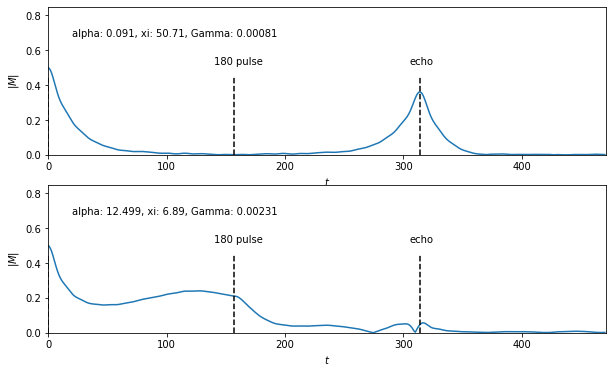

In [3]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(2,1, figsize=(10,6));

plot_idx1 = 228; # change this to see different curves
plot_idx2 = 0; # change this to see different curves

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, Gamma: %.5f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

# Evaluation Task 1:

Although the above example allows us to look at two pairs of curves, it would be very tedious to iterate through the entire dataset like this!
As a warmup, make a visualization of the first 500 M(t) curves of the dataset.
What features seem to be universal? Are there any outliers?


## Initial visualization and observations:

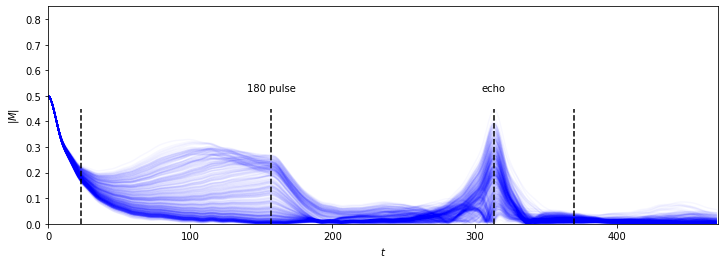

In [4]:
n = 500 # number of curves and corresponding  α  |   ξ  |   Γ values to visualize
fig1, ax1 = plt.subplots(1,1, figsize=(12,4));
for plot_idx1 in range(0, n):
  ax1.plot(abs(M[plot_idx1,:]), color=(0, 0, 1, 0.03));
ax1.plot([157, 157],[0, .45],'--k')
ax1.plot([23, 23],[0, .45],'--k')
ax1.plot([370, 370],[0, .45],'--k')
ax1.text(140,0.52,"180 pulse")
ax1.text(305,0.52,"echo")
ax1.plot([2*157, 2*157],[0, .45],'--k')
ax1.axis([0, 471, 0, 0.85])
ax1.set(ylabel="$|M|$", xlabel="$t$");
plt.show()

Immediately, some observations can be made:

1. Most of the curves fall between some values of $|M|$ for each time unit and there is a close continuos relation (using InterQuartile Range might not work). If I model the pattern based on the rate of change of $|M|$ with respect to time, it might help in identifying outliers.

2. Standard spin-echo (if it occurs) occurs at same time stamp in all the curves. Value of $|M|$ at that time stamp could be a feature and mean value could also highlight a pattern.

3. If the value of $|M|$ increases before $t = 50$ - instead of exponentially decreasing, it might be a case of coupled spin-echo.

4. $|M|$ is probably similar in all curves before $t = 22$ and after $t = 370$.

To find out more about these features, I would use classification/clustering techniques. Those might also help me in identifying outliers.

## Outlier removal:

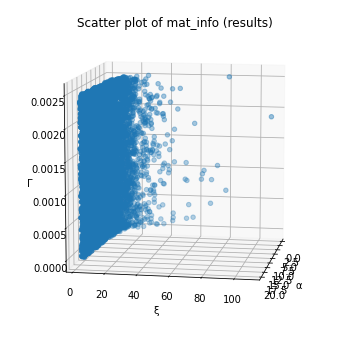

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(mat_info[:, 0], mat_info[:, 1], mat_info[:, 2])
ax.view_init(10, 10)
ax.set_xlabel('α')
ax.set_ylabel('ξ')
ax.set_zlabel('Γ')
ax.set_title("Scatter plot of mat_info (results)")
plt.show()

### Removing result outliers:

This immediately shows that there are very few datapoints (possible result outliers) with a high $ξ$ value in the entire dataset. Majority of the $ξ$ values are below 25.

Next, plotting histograms for $α$, $ξ$ and $Γ$ for further analysis.

Since I am using the whole dataset for EDA till now, it would be a good practice here to split it into a random training, validation and test set and only use training set for data analysis.

Splits: Training = $71.4\%$, Validation = $13.6\%$, Test = $15\%$

In [6]:
x_train_val, x_test, y_train_val, y_test = sklearn.model_selection.train_test_split(M, mat_info, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train_val, y_train_val, test_size=0.16, random_state=42)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(4284, 471)
(4284, 3)
(816, 471)
(816, 3)
(900, 471)
(900, 3)


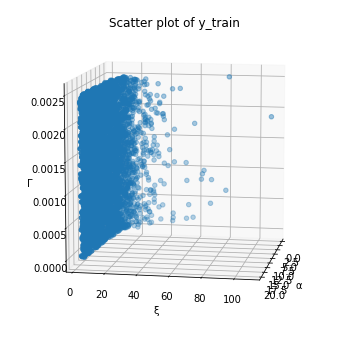

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(y_train[:, 0], y_train[:, 1], y_train[:, 2])
ax.view_init(10, 10)
ax.set_xlabel('α')
ax.set_ylabel('ξ')
ax.set_zlabel('Γ')
ax.set_title("Scatter plot of y_train")
plt.show()

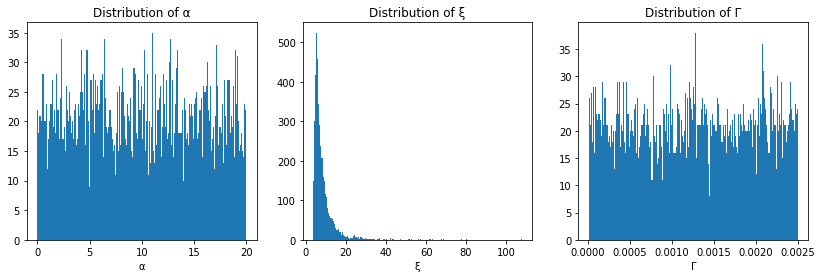

In [9]:
n_bins = 200
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(y_train[:, 0], bins=n_bins)
ax[1].hist(y_train[:, 1], bins=n_bins)
ax[2].hist(y_train[:, 2], bins=n_bins)
ax[0].set_xlabel('α')
ax[1].set_xlabel('ξ')
ax[2].set_xlabel('Γ')
ax[0].set_title("Distribution of α")
ax[1].set_title("Distribution of ξ")
ax[2].set_title("Distribution of Γ")
plt.show()

$ξ$ is heavily skewed to the right ($+ve$ skewness). Removing datapoints which are more than $3$ standard deviations away from mean of $ξ$.

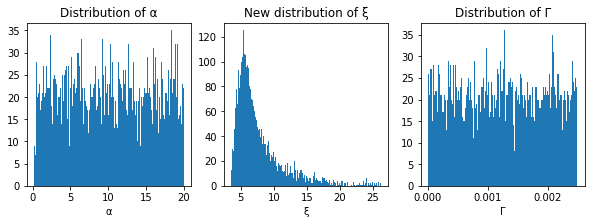

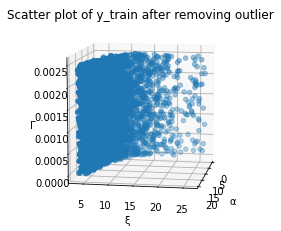

In [10]:
df1 = pd.DataFrame(y_train)
df2 = pd.DataFrame(x_train, columns=np.arange(3, 3+471, 1).tolist())
df = pd.concat([df1, df2], axis=1)
df['z_score'] = stats.zscore(df[1])
initial_size = df.shape[0]
df = df.loc[df['z_score'].abs() <= 3]
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(df[0], bins=n_bins)
ax[1].hist(df[1], bins=n_bins)
ax[2].hist(df[2], bins=n_bins)
ax[0].set_xlabel('α')
ax[1].set_xlabel('ξ')
ax[2].set_xlabel('Γ')
ax[0].set_title("Distribution of α")
ax[1].set_title("New distribution of ξ")
ax[2].set_title("Distribution of Γ")
fig2 = plt.figure(figsize=(4, 4))
ax3 = fig2.add_subplot(projection='3d')
ax3.scatter(df[0], df[1], df[2])
ax3.set_xlabel('α')
ax3.set_ylabel('ξ')
ax3.set_zlabel('Γ')
ax3.set_title("Scatter plot of y_train after removing outlier")
ax3.view_init(10, 10)
plt.show()

In [11]:
print(initial_size - df.shape[0], "datapoints have been removed as outliers.")

82 datapoints have been removed as outliers.


Some outliers have been removed from the training set based on the value of $ξ$. 

## Additional notes:

1. We could also use other outlier removal models like Isolation Forest, Local Outlier Factor, One-Class SVM etc.

2. I would also like to use Time series "clustering" methods to remove outliers.

3. Exponential smoothning was not required.

4. Not regressing between $\alpha$, $\xi$ and $Γ$ currently.

# Evaluation Task 2:

Before building the model, first randomly partition the 6000 curves into a training set and a testing set.


Dataset already split in the task above. Converting dataframe back to ndarray for convenience.

In [12]:
# Dataset already split in the task above. Converting dataframe back to ndarray for convenience.
x_train = np.array(df.iloc[:, 3:-1])
y_train = np.array(df.iloc[:, 0:3])
print(x_train.shape)
print(y_train.shape)
x_train = abs(x_train)
x_val = abs(x_val)
x_test = abs(x_test)

(4202, 471)
(4202, 3)


# Evaluation Task 3:

Optimize a model using the training set to predict $\alpha$, $\xi$, and $\Gamma$ based on $M(t)$.

(Note: feel free to use any ML algorithim/model you want, from linear regression to a full neural net!)

## Overview:

I have created a weighted ensemble model comprising of three subnetworks:

1. Random Forest over statistical features
2. InceptionTime - SOTA model for time series tasks
3. A custom CNN - for feature extraction and regression

Weighted average of preditions from these subnetworks are considered as final predictions. Weights of weighted average model are learnt from our dataset while training. All three values $\alpha$, $\xi$, and $\Gamma$ are considered independent for now.

Final predictions are made on the test set. Results in the end.

## Subnetwork $1$: Random Forest over extracted statistical features

Extracting around $700$ interpretable statistical features using `tsfresh` library. Using only the values of $|M|$ for time range $[22, 370]$, as rest pattern was universal.

Example features include **absolute maximum/minimum value, autocorrelation for different lags (ACF), autoregressive (AR) coefficients, unit root presence, quantiles, count above mean, c3 stats (non-linearity), fourier transform stats, PACF, peaks** etc.

Source: https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [13]:
def trimtotimestamp(x):
  return x[:, 22:371]

In [14]:
x_train_trimmed = trimtotimestamp(x_train)
print(x_train_trimmed.shape)

(4202, 349)


In [15]:
def getTSFeaturesTraining(x):
  # converting dataset into input format expected by tsfresh
  hello = x
  tempo = pd.DataFrame()
  ids = np.array(np.arange(0, hello.shape[0], 1).reshape((1, hello.shape[0])).T.tolist()*hello.shape[1]).reshape((hello.shape[1], hello.shape[0])).reshape((-1, 1), order='F')
  ids = ids.T[0]
  tempo['id'] = ids
  tempo['time'] = (np.arange(0, hello[0].size, 1).tolist())*hello.shape[0]
  tempo['M'] = x.T.reshape((-1, 1), order='F').T[0]
  # takes long time to execute for all complete features, since computational resources are limited, using only features defined in the 'EfficientFCParameters'
  # using n_jobs = 4
  extracted_features = extract_features(tempo, column_id="id", column_sort="time", default_fc_parameters=tsfresh.feature_extraction.EfficientFCParameters(), n_jobs=4)
  tsfresh.utilities.dataframe_functions.impute(extracted_features)
  return extracted_features

def selectRelevantFeaturesAndGetDict(extracted_features, y):
  features_filtered = tsfresh.select_features(extracted_features, pd.Series(y))
  kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(features_filtered)
  return features_filtered, kind_to_fc_parameters

In [16]:
extracted_features = getTSFeaturesTraining(x_train_trimmed)

Feature Extraction: 100%|██████████| 20/20 [10:27<00:00, 31.39s/it]


In [17]:
# getting relevant features to predict alpha, xi and gamma
features_alpha, features_dict_alpha = selectRelevantFeaturesAndGetDict(extracted_features, y_train[:, 0])
features_xi, features_dict_xi = selectRelevantFeaturesAndGetDict(extracted_features, y_train[:, 1])
features_gamma, features_dict_gamma = selectRelevantFeaturesAndGetDict(extracted_features, y_train[:, 2])
features_alpha = features_alpha.reindex(sorted(features_alpha.columns), axis=1)
features_xi = features_xi.reindex(sorted(features_xi.columns), axis=1)
features_gamma = features_gamma.reindex(sorted(features_gamma.columns), axis=1)

In [18]:
# storing for convenience
f = open("features_dict_alpha.json","w")
f.write(json.dumps(features_dict_alpha))
f.close()
f = open("features_dict_xi.json","w")
f.write(json.dumps(features_dict_xi))
f.close()
f = open("features_dict_gamma.json","w")
f.write(json.dumps(features_dict_gamma))
f.close()
extracted_features.to_csv('extracted_train.csv')

In [19]:
def train_rf(features, y, n_estimators=100):
  regressor = RandomForestRegressor(n_estimators, random_state=0)
  regressor.fit(features, y)
  return regressor

In [20]:
# Training 3 RandomForest models
regressor_alpha = train_rf(features_alpha, y_train[:, 0], n_estimators=80)
regressor_xi = train_rf(features_xi, y_train[:, 1], n_estimators=250)
regressor_gamma = train_rf(features_gamma, y_train[:, 2], n_estimators=100)

## Subnetwork $2$: InceptionTime (Fawaz, 2019) - SOTA for time series tasks

https://arxiv.org/pdf/1909.04939.pdf

In [21]:
def train_transformer(x_train, x_val, y_train, y_val, bs=256, model=InceptionTime, epochs=150, lr=6e-4):
  x_train_3d = to3d(x_train)
  x_val_3d = to3d(x_val)
  x, y, splits = combine_split_data([x_train_3d, x_val_3d], [y_train, y_val])
  tfms  = [None, [TSRegression()]]
  batch_tfms = TSStandardize(by_sample=True, by_var=True)
  dls = get_ts_dls(x, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=bs)
  learn = ts_learner(dls, model, metrics=[mae, rmse], cbs=ShowGraph())
  learn.fit_one_cycle(epochs, lr)
  return learn

epoch,train_loss,valid_loss,mae,_rmse,time
0,135.244354,140.350601,10.397882,11.846966,00:05
1,133.391800,139.582199,10.361230,11.814492,00:05
2,130.931412,134.935196,10.139273,11.616160,00:05
3,128.728775,130.481064,9.922792,11.422831,00:05
4,126.719948,126.871094,9.745876,11.263707,00:05
5,124.554726,124.270134,9.617948,11.147652,00:05
6,122.291023,121.464958,9.478850,11.021113,00:05
7,119.939247,118.404411,9.326584,10.881379,00:05
8,117.694695,115.718323,9.193856,10.757244,00:05
9,115.299950,113.385475,9.078945,10.648262,00:05


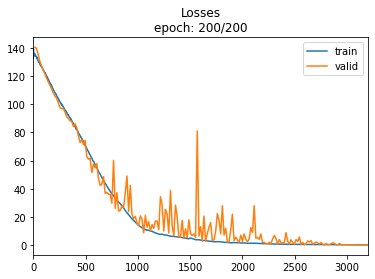

In [22]:
learner_for_alpha = train_transformer(x_train, x_val, y_train[:, 0], y_val[:, 0], 256, InceptionTime, 200, 2e-4)

epoch,train_loss,valid_loss,mae,_rmse,time
0,77.105942,87.983810,8.140758,9.379969,00:05
1,76.036072,87.246498,8.095860,9.340584,00:05
2,75.146194,83.575706,7.866234,9.141975,00:05
3,74.059792,80.932617,7.696521,8.996256,00:05
4,73.043732,79.148270,7.580149,8.896531,00:05
5,71.692352,77.613525,7.478712,8.809855,00:05
6,70.310387,76.158157,7.380960,8.726864,00:05
7,69.048721,74.477188,7.265922,8.630016,00:05
8,67.663193,72.764771,7.146580,8.530228,00:05
9,66.252846,70.989212,7.020626,8.425509,00:05


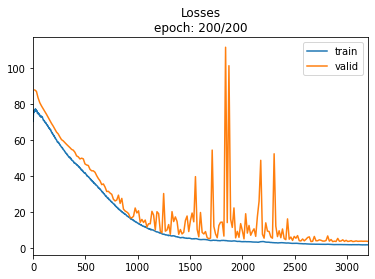

In [23]:
learner_for_xi = train_transformer(x_train, x_val, y_train[:, 1], y_val[:, 1], 256, InceptionTime, 200, 1e-4)

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.007368,0.004728,0.068136,0.068763,00:05
1,0.004233,0.003108,0.053717,0.055748,00:05
2,0.002592,0.001829,0.038685,0.042761,00:05
3,0.001719,0.000322,0.016194,0.017953,00:05
4,0.001192,0.000178,0.011996,0.013343,00:05
5,0.000836,0.000064,0.006306,0.007990,00:05
6,0.000589,0.000016,0.002945,0.003985,00:05
7,0.000420,0.000012,0.002607,0.003438,00:05
8,0.000301,0.000007,0.002107,0.002557,00:05
9,0.000217,0.000007,0.002244,0.002682,00:05


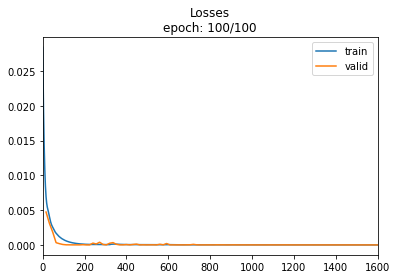

In [24]:
learner_for_gamma = train_transformer(x_train, x_val, y_train[:, 2], y_val[:, 2], 256, InceptionTime, 100, 2e-4)

## Subnetwork $3$: Custom CNN - My CNN model to learn features of TS and regress for $\alpha, \xi, Γ$

In [25]:
def tscnn(x_train, adam_optimizer_value):
  input = tf.keras.Input(shape=(x_train.shape[1], 1), dtype=tf.float64)
  conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=30, activation='relu')(input)
  pool1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=1)(conv1)
  dropout1 = tf.keras.layers.Dropout(0.1)(pool1)
  conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(dropout1)
  pool2 = tf.keras.layers.AveragePooling1D(pool_size=3, strides=1)(conv2)
  conv3 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, activation='tanh')(pool2)
  conv4 = tf.keras.layers.Conv1D(filters=64, kernel_size=30, activation='tanh')(conv3)
  pool4 = tf.keras.layers.MaxPool1D(pool_size=4, strides=1)(conv4)
  flatten = tf.keras.layers.Flatten()(pool4)
  dense1 = tf.keras.layers.Dense(units=400, activation='tanh')(flatten)
  dense2 = tf.keras.layers.Dense(units=400, activation='relu')(dense1)
  dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
  dense3 = tf.keras.layers.Dense(units=20, activation='relu')(dropout2)
  out = tf.keras.layers.Dense(1, activation='relu', name="final_output_tscnn")(dense3)

  model = tf.keras.Model(inputs=input, outputs=out, name='tscnn')

  loss = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(lr=adam_optimizer_value)
  metrics=['mse']

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [26]:
def es(patience=25):
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience, restore_best_weights=True)

In [27]:
tscnn_alpha = tscnn(x_train, 1e-4)
tscnn_xi = tscnn(x_train, 1e-4)
tscnn_gamma = tscnn(x_train, 1e-4)
tscnn_alpha.summary()
# tf.keras.utils.plot_model(tscnn_alpha)

Model: "tscnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 471, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 442, 64)           1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 440, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 440, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 438, 64)           12352     
_________________________________________________________________
average_pooling1d (AveragePo (None, 436, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 387, 64)           204864

In [28]:
history_alpha = tscnn_alpha.fit(x_train, y_train[:, 0], validation_data = (x_val, y_val[:, 0]), epochs=400, batch_size=64, callbacks=[es(patience=40)])

Epoch 1/400
66/66 [==============================] - 35s 62ms/step - loss: 67.2342 - mse: 67.2342 - val_loss: 32.1216 - val_mse: 32.1216
Epoch 2/400
66/66 [==============================] - 3s 42ms/step - loss: 32.1863 - mse: 32.1863 - val_loss: 31.6342 - val_mse: 31.6342
Epoch 3/400
66/66 [==============================] - 3s 42ms/step - loss: 31.4639 - mse: 31.4639 - val_loss: 31.6308 - val_mse: 31.6308
Epoch 4/400
66/66 [==============================] - 3s 43ms/step - loss: 31.0749 - mse: 31.0749 - val_loss: 31.7214 - val_mse: 31.7214
Epoch 5/400
66/66 [==============================] - 3s 43ms/step - loss: 32.0113 - mse: 32.0113 - val_loss: 31.5996 - val_mse: 31.5996
Epoch 6/400
66/66 [==============================] - 3s 42ms/step - loss: 31.6846 - mse: 31.6846 - val_loss: 30.6193 - val_mse: 30.6193
Epoch 7/400
66/66 [==============================] - 3s 43ms/step - loss: 30.2661 - mse: 30.2661 - val_loss: 30.1252 - val_mse: 30.1252
Epoch 8/400
66/66 [============================

In [29]:
history_xi = tscnn_xi.fit(x_train, y_train[:, 1], validation_data = (x_val, y_val[:, 1]), epochs=200, batch_size=64, callbacks=[es(patience=40)])

Epoch 1/200
66/66 [==============================] - 4s 46ms/step - loss: 33.2510 - mse: 33.2510 - val_loss: 21.3815 - val_mse: 21.3815
Epoch 2/200
66/66 [==============================] - 3s 43ms/step - loss: 14.7119 - mse: 14.7119 - val_loss: 21.2850 - val_mse: 21.2850
Epoch 3/200
66/66 [==============================] - 3s 43ms/step - loss: 14.9951 - mse: 14.9951 - val_loss: 22.9296 - val_mse: 22.9296
Epoch 4/200
66/66 [==============================] - 3s 43ms/step - loss: 14.4215 - mse: 14.4215 - val_loss: 21.6596 - val_mse: 21.6596
Epoch 5/200
66/66 [==============================] - 3s 43ms/step - loss: 14.9657 - mse: 14.9657 - val_loss: 22.5461 - val_mse: 22.5461
Epoch 6/200
66/66 [==============================] - 3s 43ms/step - loss: 14.9692 - mse: 14.9692 - val_loss: 20.9035 - val_mse: 20.9035
Epoch 7/200
66/66 [==============================] - 3s 43ms/step - loss: 14.2903 - mse: 14.2903 - val_loss: 20.6771 - val_mse: 20.6771
Epoch 8/200
66/66 [=============================

In [30]:
history_gamma = tscnn_gamma.fit(x_train*1000, y_train[:, 2]*1000, validation_data = (x_val*1000, y_val[:, 2]*1000), epochs=200, batch_size=64, callbacks=[es(patience=20)])

Epoch 1/200
66/66 [==============================] - 4s 47ms/step - loss: 1.2063 - mse: 1.2063 - val_loss: 0.1351 - val_mse: 0.1351
Epoch 2/200
66/66 [==============================] - 3s 43ms/step - loss: 0.1403 - mse: 0.1403 - val_loss: 0.1826 - val_mse: 0.1826
Epoch 3/200
66/66 [==============================] - 3s 43ms/step - loss: 0.0523 - mse: 0.0523 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 4/200
66/66 [==============================] - 3s 43ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 5/200
66/66 [==============================] - 3s 43ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 6/200
66/66 [==============================] - 3s 43ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.1054 - val_mse: 0.1054
Epoch 7/200
66/66 [==============================] - 3s 43ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.1294 - val_mse: 0.1294
Epoch 8/200
66/66 [==============================] - 3s 43ms/step - loss: 0.

## Predicting on the validation set to get the values to learn the WeightedEnsemble

In [31]:
def getTSFeaturesTest(x, feature_dict):
  # converting dataset into input format expected by tsfresh
  hello = x
  tempo = pd.DataFrame()
  ids = np.array(np.arange(0, hello.shape[0], 1).reshape((1, hello.shape[0])).T.tolist()*hello.shape[1]).reshape((hello.shape[1], hello.shape[0])).reshape((-1, 1), order='F')
  ids = ids.T[0]
  tempo['id'] = ids
  tempo['time'] = (np.arange(0, hello[0].size, 1).tolist())*hello.shape[0]
  tempo['M'] = x.T.reshape((-1, 1), order='F').T[0]
  # takes long time to execute for all complete features, since computational resources are limited, using only features in provided dictionary'
  # using n_jobs = 4
  # extracted_features = extract_features(tempo, column_id="id", column_sort="time", default_fc_parameters=tsfresh.feature_extraction.EfficientFCParameters(), n_jobs=4)
  extracted_features = extract_features(tempo, column_id="id", column_sort="time", kind_to_fc_parameters=feature_dict , n_jobs=4)
  extracted_features = extracted_features.replace('NaN', 0)
  return extracted_features

In [32]:
# extracting only those features which were termed as relevant while training (using a stored dictionary for this purpose)
x_val_trimmed = trimtotimestamp(x_val)
features_alpha_val = getTSFeaturesTest(x_val_trimmed, features_dict_alpha)
features_xi_val = getTSFeaturesTest(x_val_trimmed, features_dict_xi)
features_gamma_val = getTSFeaturesTest(x_val_trimmed, features_dict_gamma)
features_alpha_val = features_alpha_val.reindex(sorted(features_alpha_val.columns), axis=1)
features_xi_val = features_xi_val.reindex(sorted(features_xi_val.columns), axis=1)
features_gamma_val = features_gamma_val.reindex(sorted(features_gamma_val.columns), axis=1)

Feature Extraction: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


In [33]:
# Validation set predictions from Random forest
y_pred_val_rf_alpha = regressor_alpha.predict(features_alpha_val)
y_pred_val_rf_xi = regressor_xi.predict(features_xi_val)
y_pred_val_rf_gamma = regressor_gamma.predict(features_gamma_val)

In [34]:
def getdls(x_val):
  # x_train_3d = to3d(x_train)
  x_val_3d = to3d(x_val)
  x, y, splits = combine_split_data([x_val_3d, x_val_3d], [np.zeros(x_val.shape[0]), np.zeros(x_val.shape[0])])
  # check_data(x, y, splits)
  tfms  = [None, [TSRegression()]]
  batch_tfms = TSStandardize(by_sample=True, by_var=True)
  dls = get_ts_dls(x, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=256)
  return dls

In [35]:
# Validation set predictions from InceptionTime
learner_for_alpha.dls = getdls(x_val)
learner_for_xi.dls = getdls(x_val)
learner_for_gamma.dls = getdls(x_val)
valid_preds, valid_targets = learner_for_alpha.get_preds(ds_idx=1)
y_pred_val_transformer_alpha = np.array(valid_preds.flatten().data)
valid_preds, valid_targets = learner_for_xi.get_preds(ds_idx=1)
y_pred_val_transformer_xi = np.array(valid_preds.flatten().data)
valid_preds, valid_targets = learner_for_gamma.get_preds(ds_idx=1)
y_pred_val_transformer_gamma = np.array(valid_preds.flatten().data)

Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


In [36]:
# Validation set predictions from my CNN
y_pred_val_cnn_alpha = tscnn_alpha.predict(x_val, 64).T.reshape(x_val.shape[0],)
y_pred_val_cnn_xi = tscnn_xi.predict(x_val, 64).T.reshape(x_val.shape[0],)
y_pred_val_cnn_gamma = tscnn_gamma.predict(x_val, 64).T.reshape(x_val.shape[0],)

In [37]:
print(y_pred_val_rf_alpha.shape)
print(y_pred_val_transformer_alpha.shape)
print(y_pred_val_cnn_alpha.shape)

(816,)
(816,)
(816,)


## Weighted Ensemble

Training its weights from predictions on the validation set

In [38]:
def formattoweightedavg(rf, trans, cnn):
  return np.array([rf, trans, cnn]).T

In [39]:
# rf | trans | cnn
x_weighted_avg_alpha = formattoweightedavg(y_pred_val_rf_alpha, y_pred_val_transformer_alpha, y_pred_val_cnn_alpha)
x_weighted_avg_xi = formattoweightedavg(y_pred_val_rf_xi, y_pred_val_transformer_xi, y_pred_val_cnn_xi)
x_weighted_avg_gamma = formattoweightedavg(y_pred_val_rf_gamma, y_pred_val_transformer_gamma, y_pred_val_cnn_gamma)

In [40]:
def weighted_average(lr):
  input = tf.keras.Input(shape=(3, ), dtype=tf.float64)
  dense = tf.keras.layers.Dense(units=1, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.5), use_bias=False)(input)
  model = tf.keras.Model(inputs=input, outputs=dense, name='weighted_average')
  model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics='mse')
  return model
weighted_average_alpha = weighted_average(5e-3)
weighted_average_xi = weighted_average(5e-3)
weighted_average_gamma = weighted_average(5e-3)
weighted_average_alpha.summary()

Model: "weighted_average"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [41]:
history_weight_alpha = weighted_average_alpha.fit(x_weighted_avg_alpha, y_val[:, 0], validation_split=0.2, epochs=500, batch_size=32, callbacks=[es(patience=40)])

Epoch 1/500
21/21 [==============================] - 1s 12ms/step - loss: 10.7481 - mse: 10.7481 - val_loss: 3.7973 - val_mse: 3.7973
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 4.6687 - mse: 4.6687 - val_loss: 3.8507 - val_mse: 3.8507
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 4.6064 - mse: 4.6064 - val_loss: 3.5904 - val_mse: 3.5904
Epoch 4/500
21/21 [==============================] - 0s 5ms/step - loss: 4.3356 - mse: 4.3356 - val_loss: 3.4536 - val_mse: 3.4536
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 4.1584 - mse: 4.1584 - val_loss: 3.3310 - val_mse: 3.3310
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 3.7123 - mse: 3.7123 - val_loss: 3.1857 - val_mse: 3.1857
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 3.5650 - mse: 3.5650 - val_loss: 3.0333 - val_mse: 3.0333
Epoch 8/500
21/21 [==============================] - 0s 4ms/step - loss: 4.0138 

In [42]:
history_weight_xi = weighted_average_xi.fit(x_weighted_avg_xi, y_val[:, 1], validation_split=0.2, epochs=500, batch_size=32, callbacks=[es(patience=40)])

Epoch 1/500
21/21 [==============================] - 1s 12ms/step - loss: 18.4825 - mse: 18.4825 - val_loss: 5.0913 - val_mse: 5.0913
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 6.8259 - mse: 6.8259 - val_loss: 2.6711 - val_mse: 2.6711
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 4.0038 - mse: 4.0038 - val_loss: 2.7926 - val_mse: 2.7926
Epoch 4/500
21/21 [==============================] - 0s 5ms/step - loss: 3.3590 - mse: 3.3590 - val_loss: 2.6979 - val_mse: 2.6979
Epoch 5/500
21/21 [==============================] - 0s 5ms/step - loss: 4.9388 - mse: 4.9388 - val_loss: 2.6469 - val_mse: 2.6469
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 4.1700 - mse: 4.1700 - val_loss: 2.6492 - val_mse: 2.6492
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 3.2303 - mse: 3.2303 - val_loss: 2.6598 - val_mse: 2.6598
Epoch 8/500
21/21 [==============================] - 0s 5ms/step - loss: 4.0787 

In [43]:
history_weight_gamma = weighted_average_gamma.fit(x_weighted_avg_gamma*1000, y_val[:, 2]*1000, validation_split=0.2, epochs=500, batch_size=32, callbacks=[es(patience=40)])

Epoch 1/500
21/21 [==============================] - 1s 11ms/step - loss: 13410.2611 - mse: 13410.2611 - val_loss: 7054.8862 - val_mse: 7054.8862
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 5602.6609 - mse: 5602.6609 - val_loss: 2309.4255 - val_mse: 2309.4255
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 1716.8102 - mse: 1716.8102 - val_loss: 522.3028 - val_mse: 522.3028
Epoch 4/500
21/21 [==============================] - 0s 5ms/step - loss: 356.3951 - mse: 356.3951 - val_loss: 69.5098 - val_mse: 69.5098
Epoch 5/500
21/21 [==============================] - 0s 6ms/step - loss: 42.2737 - mse: 42.2737 - val_loss: 3.9726 - val_mse: 3.9726
Epoch 6/500
21/21 [==============================] - 0s 5ms/step - loss: 2.0987 - mse: 2.0987 - val_loss: 0.2539 - val_mse: 0.2539
Epoch 7/500
21/21 [==============================] - 0s 5ms/step - loss: 0.2662 - mse: 0.2662 - val_loss: 0.2996 - val_mse: 0.2996
Epoch 8/500
21/21 [===================

# Evaluation Task 4:
   
Validate the trained model on the testing partition of the dataset. Also visualize how your model's predicted values of $\alpha$, $\xi$, and $\Gamma$ compare to their true values from mat_info.txt.

Finally testing the model on the test set.

In [44]:
# getting predictions on the test set
x_test_trimmed = trimtotimestamp(x_test)
features_alpha_test = getTSFeaturesTest(x_test_trimmed, features_dict_alpha)
features_xi_test = getTSFeaturesTest(x_test_trimmed, features_dict_xi)
features_gamma_test = getTSFeaturesTest(x_test_trimmed, features_dict_gamma)
features_alpha_test = features_alpha_test.reindex(sorted(features_alpha_test.columns), axis=1)
features_xi_test = features_xi_test.reindex(sorted(features_xi_test.columns), axis=1)
features_gamma_test = features_gamma_test.reindex(sorted(features_gamma_test.columns), axis=1)

y_pred_test_rf_alpha = regressor_alpha.predict(features_alpha_test)
y_pred_test_rf_xi = regressor_xi.predict(features_xi_test)
y_pred_test_rf_gamma = regressor_gamma.predict(features_gamma_test)

learner_for_alpha.dls = getdls(x_test)
learner_for_xi.dls = getdls(x_test)
learner_for_gamma.dls = getdls(x_test)
valid_preds, valid_targets = learner_for_alpha.get_preds(ds_idx=1)
y_pred_test_transformer_alpha = np.array(valid_preds.flatten().data)
valid_preds, valid_targets = learner_for_xi.get_preds(ds_idx=1)
y_pred_test_transformer_xi = np.array(valid_preds.flatten().data)
valid_preds, valid_targets = learner_for_gamma.get_preds(ds_idx=1)
y_pred_test_transformer_gamma = np.array(valid_preds.flatten().data)

Feature Extraction: 100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


Could not do one pass in your dataloader, there is something wrong in it
Could not do one pass in your dataloader, there is something wrong in it


In [45]:
y_pred_test_cnn_alpha = tscnn_alpha.predict(x_test, 64).T.reshape(x_test.shape[0],)
y_pred_test_cnn_xi = tscnn_xi.predict(x_test, 64).T.reshape(x_test.shape[0],)
y_pred_test_cnn_gamma = tscnn_gamma.predict(x_test*1000, 64).T.reshape(x_test.shape[0],)/1000

print(y_pred_test_rf_alpha.shape)
print(y_pred_test_transformer_alpha.shape)
print(y_pred_test_cnn_alpha.shape)

x_weighted_avg_alpha_test = formattoweightedavg(y_pred_test_rf_alpha, y_pred_test_transformer_alpha, y_pred_test_cnn_alpha)
x_weighted_avg_xi_test = formattoweightedavg(y_pred_test_rf_xi, y_pred_test_transformer_xi, y_pred_test_cnn_xi)
x_weighted_avg_gamma_test = formattoweightedavg(y_pred_test_rf_gamma, y_pred_test_transformer_gamma, y_pred_test_cnn_gamma)

(900,)
(900,)
(900,)


In [46]:
# getting final predictions on the test set from weighted ensemble
y_pred_alpha = weighted_average_alpha.predict(x_weighted_avg_alpha_test, 32).T.reshape((x_weighted_avg_alpha_test.shape[0], ))
y_pred_xi = weighted_average_xi.predict(x_weighted_avg_xi_test, 32).T.reshape((x_weighted_avg_xi_test.shape[0], ))
y_pred_gamma = weighted_average_gamma.predict(x_weighted_avg_gamma_test*1000, 32).T.reshape((x_weighted_avg_gamma_test.shape[0], ))/1000

# Visualizing final predictions:

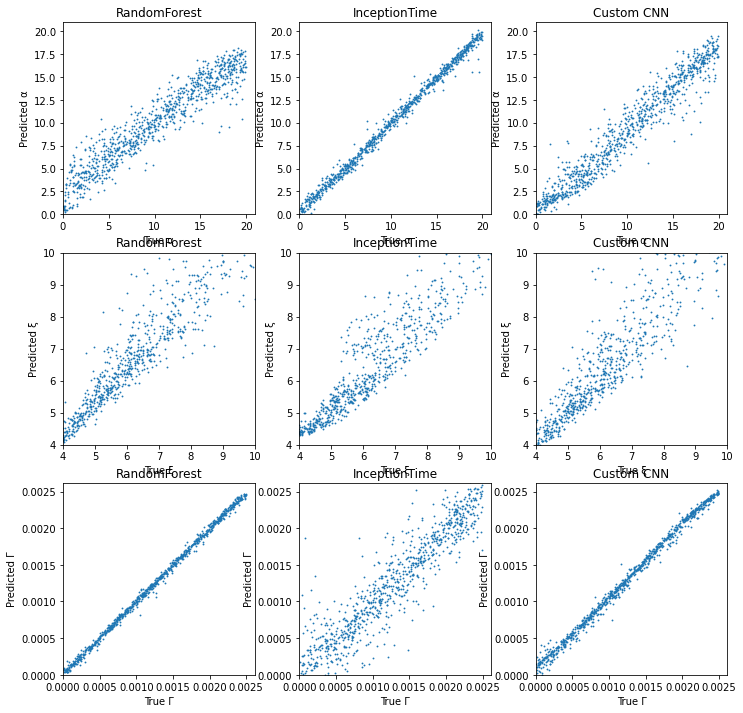

In [47]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax[0][0].scatter(y_test[:, 0], y_pred_test_rf_alpha, s=0.7)
ax[0][1].scatter(y_test[:, 0], y_pred_test_transformer_alpha, s=0.7)
ax[0][2].scatter(y_test[:, 0], y_pred_test_cnn_alpha, s=0.7)
ax[1][0].scatter(y_test[:, 1], y_pred_test_rf_xi, s=0.7)
ax[1][1].scatter(y_test[:, 1], y_pred_test_transformer_xi, s=0.7)
ax[1][2].scatter(y_test[:, 1], y_pred_test_cnn_xi, s=0.7)
ax[2][0].scatter(y_test[:, 2], y_pred_test_rf_gamma, s=0.7)
ax[2][1].scatter(y_test[:, 2], y_pred_test_transformer_gamma, s=0.7)
ax[2][2].scatter(y_test[:, 2], y_pred_test_cnn_gamma, s=0.7)
for i in range (3):
  for j in range(3):
    ax[i][j].axis([0, ax[i][j].axis()[1], 0, ax[i][j].axis()[1]])
    ax[i][j].set_aspect(aspect=1)
for i in range(3):
  ax[0][i].set_xlabel("True α")
  ax[0][i].set_ylabel("Predicted α")
  ax[1][i].set_xlabel("True ξ")
  ax[1][i].set_ylabel("Predicted ξ")
  ax[2][i].set_xlabel("True Γ")
  ax[2][i].set_ylabel("Predicted Γ")
  ax[i][0].set_title("RandomForest")
  ax[i][1].set_title("InceptionTime")
  ax[i][2].set_title("Custom CNN")
  ax[1][i].axis([4, 10, 4, 10])
plt.show()

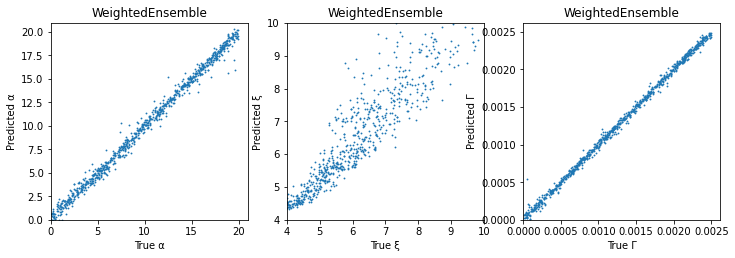

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(y_test[:, 0], y_pred_alpha, s=0.7)
ax[1].scatter(y_test[:, 1], y_pred_xi, s=0.7)
ax[2].scatter(y_test[:, 2], y_pred_gamma, s=0.7)
for i in range (3):
    ax[i].axis([0, ax[i].axis()[1], 0, ax[i].axis()[1]])
    ax[i].set_aspect(aspect=1)
    ax[i].set_title("WeightedEnsemble")
ax[1].axis([4, 10, 4, 10])
ax[0].set_xlabel("True α")
ax[0].set_ylabel("Predicted α")
ax[1].set_xlabel("True ξ")
ax[1].set_ylabel("Predicted ξ")
ax[2].set_xlabel("True Γ")
ax[2].set_ylabel("Predicted Γ")
plt.show()

In [49]:
def rmse(y_true, y_pred):
  return np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))

# Results:

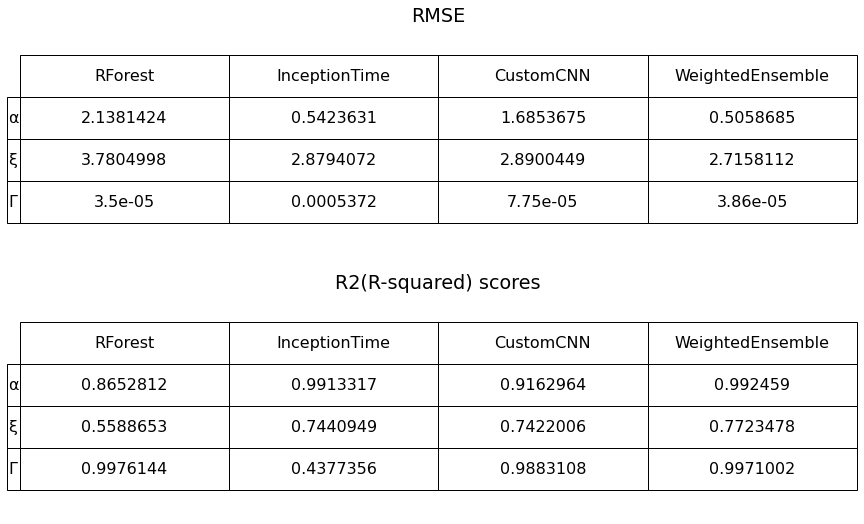

In [50]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
for x in ax:
  x.set_axis_off()
r2 = sklearn.metrics.r2_score
rmseval = [
           [rmse(y_test[:, 0], y_pred_test_rf_alpha), rmse(y_test[:, 0], y_pred_test_transformer_alpha), rmse(y_test[:, 0], y_pred_test_cnn_alpha), rmse(y_test[:, 0], y_pred_alpha)],
           [rmse(y_test[:, 1], y_pred_test_rf_xi), rmse(y_test[:, 1], y_pred_test_transformer_xi), rmse(y_test[:, 1], y_pred_test_cnn_xi), rmse(y_test[:, 1], y_pred_xi)],
           [rmse(y_test[:, 2], y_pred_test_rf_gamma), rmse(y_test[:, 2], y_pred_test_transformer_gamma), rmse(y_test[:, 2], y_pred_test_cnn_gamma), rmse(y_test[:, 2], y_pred_gamma)],
           ]
r2val = [
           [r2(y_test[:, 0], y_pred_test_rf_alpha), r2(y_test[:, 0], y_pred_test_transformer_alpha), r2(y_test[:, 0], y_pred_test_cnn_alpha), r2(y_test[:, 0], y_pred_alpha)],
           [r2(y_test[:, 1], y_pred_test_rf_xi), r2(y_test[:, 1], y_pred_test_transformer_xi), r2(y_test[:, 1], y_pred_test_cnn_xi), r2(y_test[:, 1], y_pred_xi)],
           [r2(y_test[:, 2], y_pred_test_rf_gamma), r2(y_test[:, 2], y_pred_test_transformer_gamma), r2(y_test[:, 2], y_pred_test_cnn_gamma), r2(y_test[:, 2], y_pred_gamma)],
           ]
rmse_table = ax[0].table(
    colLabels=["RForest", "InceptionTime", "CustomCNN", "WeightedEnsemble"],
    rowLabels=["α", "ξ", "Γ"],
    cellText=np.array(rmseval).round(7),
    loc='center',
    cellLoc='center'
)
ax[0].set_title("RMSE")
r2_table = ax[1].table(
    colLabels=["RForest", "InceptionTime", "CustomCNN", "WeightedEnsemble"],
    rowLabels=["α", "ξ", "Γ"],
    cellText=np.array(r2val).round(7),
    loc='center',
    cellLoc='center',
)
rmse_table.auto_set_font_size(False)
r2_table.auto_set_font_size(False)
rmse_table.scale(1, 3.5)
r2_table.scale(1, 3.5)
ax[1].set_title("R2(R-squared) scores")
plt.show()

# Conclusion:

$\alpha$ was successfully predicted from InceptionTime and CNN. $\Gamma$ was successfully predicted from RandomForest and CNN. $\xi$ was best predicted from all three equally.

Better methods for $\xi$ have to be modeled.

# Additional Notes:

1. Explore regression patterns between $\alpha$, $\xi$, and $\Gamma$.

    Is it possible to predict $\xi$ from $\alpha$ or $\Gamma$?

    Does a correlation between them exist? (may also help in outliers)

2. Explore models other than Random Forest. 

    Maybe linear regression, SVM? or plain MLP over statistical features?

3. Explore RNNs and **Transformer** based models for regression.

4. Visualize layers of CNN to understand what features they are picking up.

    Plot heatmaps.

    Can visualizations from CNNs help in forming a **theoretical** model?

5. Improve on outlier removal:

    * Use other outlier removal models like Isolation Forest, Local Outlier Factor, One-Class SVM etc.

    * Use time series **clustering** methods to remove outliers.

6. Tune hyperparameters.

In [51]:
# Thank you!